![AIcrowd-Logo](https://images.aicrowd.com/raw_images/challenges/banner_file/755/73708a8ac63b521cb3be.jpg)



<p align="center"> Join the communty! <br><a href="https://discord.gg/GTckBMx"><img src="https://img.shields.io/discord/657211973435392011?style=for-the-badge" alt="chat on Discord"></a>
</p>

<h1> <center>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁<br>
🐀 MABe Classical Classification: Baseline 💪 🐁<br>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁
</center>
</h1>

<p align="center"><img src="https://images.aicrowd.com/uploads/ckeditor/pictures/324/content_task1_structure.png">
</p>

# How to use this notebook 📝

1. **Copy the notebook**. This is a shared template and any edits you make here will not be saved. _You should copy it into your own drive folder._ For this, click the "File" menu (top-left), then "Save a Copy in Drive". You can edit your copy however you like.
2. **Link it to your AIcrowd account**. In order to submit your predictions to AIcrowd, you need to provide your account's API key.



# Approach used in Notebook

* Add future and past frames to make an input window.
* Normalize and flatten the inputs
* Use 1D convolutional network with time as the convolution axis
* Supervised classification on each input window



# Setup AIcrowd Utilities 🛠

In [ ]:
!pip install -U aicrowd-cli==0.1 > /dev/null 

# Install packages 🗃

Please add all pacakages installations in this section

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 4.0MB/s 


# Import necessary modules and packages 📚


In [1]:
import numpy as np
import os

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
import keras.layers as layers
import tensorflow_addons as tfa

import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import tqdm
import gc

# Download the dataset 📲

Please get your API key from https://www.aicrowd.com/participants/me


In [2]:
API_KEY = "0ba231d61506b40a4ae00df011cf0cb9"
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [ ]:
#Already one...........
!aicrowd dataset download --challenge mabe-task-1-classical-classification

train.npy: 100% 118M/118M [00:08<00:00, 13.4MB/s]
sample-submission.npy: 100% 65.4M/65.4M [00:05<00:00, 12.2MB/s]
test-release.npy: 100% 1.83G/1.83G [02:12<00:00, 13.8MB/s]


In [4]:
pwd

'/home/blansdel/projects/mabe-task1'

Extract the downloaded dataset to `data` directory


In [3]:
!rm -rf data
!mkdir data
 
!mv train.npy data/train.npy
!mv test-release.npy data/test.npy
!mv sample-submission.npy data/sample_submission.npy

# Load Data
The dataset files are python dictionaries, [this](https://colab.research.google.com/drive/1ddCX-TAdEcsUaGf09f5Glgr_G57FMK_O#scrollTo=JPsfxdl2GMcM&line=18&uniqifier=1) is a descirption of how the data is organized.



In [5]:
train = np.load('data/train.npy',allow_pickle=True).item()
test = np.load('data/test.npy',allow_pickle=True).item()
sample_submission = np.load('data/sample_submission.npy',allow_pickle=True).item()

## Dataset Specifications 💾

-   **`train.npy`** - Training set for the task, which follows the following schema:

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/GddvoT2.png">
</p>


-   **`test-release.npy`** - Test set for the task, which follows the following schema :

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/vfa8Y4V.png">
</p>

-   **`sample_submission.npy`** - Template for a sample submission which follows the following schema

```json
{
    "<sequence_id-1>" : [0, 0, 1, 2, ...],
    "<sequence_id-2>" : [0, 1, 2, 0, ...]
}
```

Each key in the dictionary here refers to the unique sequence id obtained for the sequences in the test set.
The value for each of the keys is expected to hold a list of corresponing annotations. The annotations are represented by the index of the corresponding annotation words in the vocabular provided in the test set.

## How does the data look like? 🔍

### Data overview

In [6]:
print("Dataset keys - ", train.keys())
print("Vocabulary - ", train['vocabulary'])
print("Number of train Sequences - ", len(train['sequences']))
print("Number of test Sequences - ", len(test['sequences']))

Dataset keys -  dict_keys(['vocabulary', 'sequences'])
Vocabulary -  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences -  70
Number of test Sequences -  458


### Sample overview

In [7]:
sequence_names = list(train["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = train["sequences"][sequence_key]
print("Sequence name - ", sequence_key)
print("Single Sequence keys ", single_sequence.keys())
print(f"Number of Frames in {sequence_key} - ", len(single_sequence['annotations']))
print(f"Keypoints data shape of {sequence_key} - ", single_sequence['keypoints'].shape)
print(f"annotator_id of {sequence_key} - ", single_sequence['annotator_id'])

Sequence name -  1cac195d39
Single Sequence keys  dict_keys(['keypoints', 'annotator_id', 'annotations'])
Number of Frames in 1cac195d39 -  4879
Keypoints data shape of 1cac195d39 -  (4879, 2, 2, 7)
annotator_id of 1cac195d39 -  0


# Helper function for visualization 💁




Don't forget to run the cell 😉

In [8]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
 
rc('animation', html='jshtml')
 
# Note: Image processing may be slow if too many frames are animated.                
 
#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570
 
RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'
 
PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
 
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
 
class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}
 
number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}
 
def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)
 
def set_figax():
    fig = plt.figure(figsize=(6, 4))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100, 
                          annotation_sequence = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(start_frame, stop_frame):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
        
        if annotation_sequence is not None:
          annot = annotation_sequence[j]
          annot = number_to_class[annot]
          plt.text(50, -20, annot, fontsize = 16, 
                   bbox=dict(facecolor=class_to_color[annot], alpha=0.5))
 
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j))
 
        ax.axis('off')
        fig.tight_layout(pad=0)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani
 
def plot_annotation_strip(annotation_sequence, start_frame = 0, stop_frame = 100, title="Behavior Labels"):
  # Plot annotations as a annotation strip.
 
  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])
 
  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))
 
  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5,0.5,1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)
 
  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:,np.newaxis].transpose(),
                                                  height, axis = 0)
  
  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation = 'none',cmap=cmap, norm=norm)
 
  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)
 
  import matplotlib.patches as mpatches
 
  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))
 
  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))
 
  plt.tight_layout()

# Visualize the mouse movements🎥

Sample visualization for plotting pose gifs.

Processing frame  3000
Processing frame  3020
Processing frame  3040
Processing frame  3060
Processing frame  3080


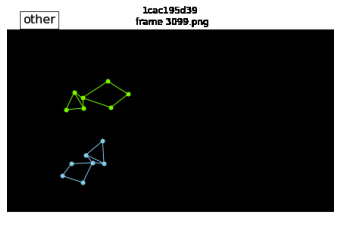

In [9]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            keypoint_sequence, 
                            start_frame = 3000,
                            stop_frame = 3100,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

### Showing annotations of one of the sequeunce of the training data (Index needs to be selected for a full video)



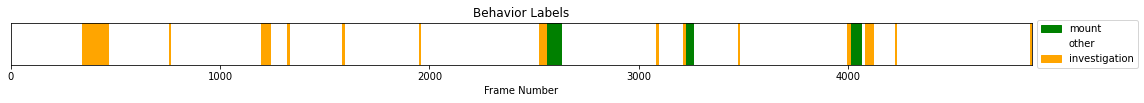

In [10]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)
 
plot_annotation_strip(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence) + 1000
)

# Basic EDA 🤓
Each sequence has different amounts of each behavior, here we get the percentage of frames of each behavior in each sequence. We can use this to split the dataset for validation in a stratified way.

In [12]:
vocabulary = train['vocabulary']
def get_percentage(sequence_key):
  anno_seq = num_to_text(train['sequences'][sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
  return counts

anno_percentages = {k: get_percentage(k) for k in train['sequences']}

anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df

Percentage of frames in every sequence for every class


,attack,investigation,mount,other
1cac195d39,0.000000,0.077885,0.033818,0.888297
b40d39ca72,0.000000,0.625136,0.000000,0.374864
f45694e6b9,0.000000,0.375125,0.000000,0.624875
9212f26324,0.015467,0.112307,0.000000,0.872226
5490af36aa,0.438260,0.285662,0.010321,0.265757
...,...,...,...,...
bf702e3c78,0.000000,0.389482,0.000000,0.610518
0f38732507,0.000000,0.283706,0.078952,0.637342
f5c7687579,0.000000,0.288732,0.026002,0.685265
cd5fbeaa98,0.000000,0.189503,0.052890,0.757607


## Percentage Frames of all behaviors

Lets look at the class imbalance!

In [13]:
all_annotations = []
for sk in train['sequences']:
  anno = train['sequences'][sk]['annotations']
  all_annotations.extend(list(anno))
all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)})

,Behavior,Percentage Frames
0,attack,0.027658
1,investigation,0.288777
2,mount,0.056372
3,other,0.627194


# Training The Model 🏋️‍♂️

The given MABe dataset contain many sequences of time series data, each frame has its own behavior label. Training on just a single frame does not give good results due to less information. 

So here past and future frames are also added to each input. But also all the frames are not concatenated as as the boundaries of the past and future frames need to stay separate for each video.


## Seeding helper
Its good practice to seed before every run, that way its easily reproduced.

In [14]:
def seed_everything(seed):
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)

seed=2021
seed_everything(seed)

## Generator 🔌

The generator is used to take input winodws from each sequence after randomly sampling frames. 

It also provides code for augmentations
1.   Random rotation
2.   Random translate

🚧 Note that these augmentations are applied in the same across all frames in a selected window, e.g - Random rotation by 10 degrees will rotate all frames in the input window by the same angle.




In [15]:
class MABe_Generator(keras.utils.Sequence):
    def __init__(self, pose_dict, 
                 batch_size, dim, 
                 use_conv, num_classes, augment=False,
                 class_to_number=None,
                 past_frames=0, future_frames=0, 
                 frame_gap=1, shuffle=False,
                 mode='fit'):
        self.batch_size = batch_size
        self.video_keys = list(pose_dict.keys())
        self.dim = dim
        self.use_conv = use_conv
        self.past_frames = past_frames
        self.future_frames = future_frames
        self.frame_gap = frame_gap
        self.shuffle = shuffle
        self.num_classes=num_classes
        self.augment = augment
        self.mode = mode

        self.class_to_number = class_to_number

        self.video_indexes = []
        self.frame_indexes = []
        self.X = {}
        if self.mode == 'fit':
          self.y = []
        self.pad = self.past_frames * self.frame_gap
        future_pad = self.future_frames * self.frame_gap
        pad_width = (self.pad, future_pad), (0, 0), (0, 0), (0, 0)
        self.seq_lengths = {}
        for vc, key in enumerate(self.video_keys):
          if self.mode == 'fit':
            anno = pose_dict[key]['annotations']
            self.y.extend(anno)
          nframes = len(pose_dict[key]['keypoints'])
          self.video_indexes.extend([vc for _ in range(nframes)])
          self.frame_indexes.extend(range(nframes))
          self.X[key] = np.pad(pose_dict[key]['keypoints'], pad_width)
          self.seq_lengths[key] = nframes
        
        if self.mode == 'fit':
          self.y = np.array(self.y)
        
        self.X_dtype = self.X[key].dtype

        self.indexes = list(range(len(self.frame_indexes)))

        if self.mode == 'predict':
          extra_predicts = -len(self.indexes) % self.batch_size # So that last part is not missed
          self.indexes.extend(self.indexes[:extra_predicts])
          self.indexes = np.array(self.indexes)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def augment_fn(self, x):
      # Rotate
      angle = (np.random.rand()-0.5) * (np.pi * 2)
      c, s = np.cos(angle), np.sin(angle)
      rot = np.array([[c, -s], [s, c]])
      x = np.dot(x, rot)

      # Shift - All get shifted together
      shift = (np.random.rand(2)-0.5) * 2 * 0.25
      x = x + shift
      return x

    def __getitem__(self, index):
        bs = self.batch_size
        indexes = self.indexes[index*bs:(index+1)*bs]
        X = np.empty((bs, *self.dim), self.X_dtype)
        if self.mode == 'predict':
          vkey_fi_list = []
        for bi, idx in enumerate(indexes):
          vkey = self.video_keys[self.video_indexes[idx]]
          fi = self.frame_indexes[idx]
          if self.mode == 'predict':
            vkey_fi_list.append((vkey, fi))
          fi = fi + self.pad
          start = fi - self.past_frames*self.frame_gap
          stop = fi + (self.future_frames + 1)*self.frame_gap
          assert start >= 0

          Xi = self.X[vkey][start:stop:self.frame_gap].copy()
          
          if self.augment:
            Xi = self.augment_fn(Xi)
          X[bi] = np.reshape(Xi, self.dim)
          

        if self.mode == 'fit':
          y_vals = self.y[indexes]
          # Converting to one hot because F1 callback needs one hot
          y = np.zeros( (bs,self.num_classes), np.float32)
          y[np.arange(bs), y_vals] = 1
          return X, y

        elif self.mode == 'predict':
          return X, vkey_fi_list

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

## Trainer 🏋️

The trainer class implements a unified interface for using the datagenerator.

It supports fully connected or 1D convolutional networks, as well as other hyperparameters for the model and the generator.

In [16]:
class Trainer:
  def __init__(self, *,
               train_data,
               val_data,
               test_data,
               feature_dim, 
               batch_size, 
               num_classes,
               augment=False,
               class_to_number=None,
               past_frames=0, 
               future_frames=0,
               frame_gap=1, 
               use_conv=False):
    flat_dim = np.prod(feature_dim)
    if use_conv:
      input_dim = ((past_frames + future_frames + 1), flat_dim,)
    else:
      input_dim = (flat_dim * (past_frames + future_frames + 1),)

    self.input_dim = input_dim
    self.use_conv=use_conv
    self.num_classes=num_classes

    c2n = {'other': 0,'investigation': 1,
                'attack' : 2, 'mount' : 3}
    self.class_to_number = class_to_number or c2n

    self.train_generator = MABe_Generator(train_data, 
                                      batch_size=batch_size, 
                                      dim=input_dim,
                                      num_classes=num_classes, 
                                      past_frames=past_frames, 
                                      future_frames=future_frames,
                                      class_to_number=self.class_to_number,
                                      use_conv=use_conv,
                                      frame_gap=frame_gap,
                                      augment=augment,
                                      shuffle=True,
                                      mode='fit')

    self.val_generator = MABe_Generator(val_data, 
                                        batch_size=batch_size, 
                                        dim=input_dim, 
                                        num_classes=num_classes, 
                                        past_frames=past_frames,
                                        future_frames=future_frames,
                                        use_conv=use_conv,
                                        class_to_number=self.class_to_number,
                                        frame_gap=frame_gap,
                                        augment=False,
                                        shuffle=False,
                                        mode='fit')
    
    if test_data is not None:
      self.test_generator = MABe_Generator(test_data, 
                                        batch_size=8192, 
                                        dim=input_dim, 
                                        num_classes=num_classes, 
                                        past_frames=past_frames,
                                        future_frames=future_frames,
                                        use_conv=use_conv,
                                        class_to_number=self.class_to_number,
                                        frame_gap=frame_gap,
                                        augment=False,
                                        shuffle=False,
                                        mode='predict')
  
  def delete_model(self):
    self.model = None
  
  def initialize_model(self, layer_channels=(512, 256), dropout_rate=0., 
                       learning_rate=1e-3, conv_size=5):

    def add_dense_bn_activate(model, out_dim, activation='relu', drop=0.):
      model.add(layers.Dense(out_dim))
      model.add(layers.BatchNormalization())
      model.add(layers.Activation('relu'))
      if drop > 0:
        model.add(layers.Dropout(rate=drop))
      return model
    
    def add_conv_bn_activate(model, out_dim, activation='relu', conv_size=3, drop=0.):
      model.add(layers.Conv1D(out_dim, conv_size))
      model.add(layers.BatchNormalization())
      model.add(layers.Activation('relu'))
      model.add(layers.MaxPooling1D(2, 2))
      if drop > 0:
        model.add(layers.Dropout(rate=drop))
      return model

    model = Sequential()
    model.add(layers.Input(self.input_dim))
    model.add(layers.BatchNormalization())
    for ch in layer_channels:
      if self.use_conv:
        model = add_conv_bn_activate(model, ch, conv_size=conv_size,
                                     drop=dropout_rate)
      else:
        model = add_dense_bn_activate(model, ch, drop=dropout_rate)
    model.add(layers.Flatten())
    model.add(layers.Dense(self.num_classes, activation='softmax'))

    metrics = [tfa.metrics.F1Score(num_classes=self.num_classes)]
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=metrics)

    self.model = model

  def _set_model(self, model):
      """ Set an external, provide initialized and compiled keras model """
      self.model = model

  def train(self, epochs=20, class_weight=None):
    if self.model is None:
      print("Please Call trainer.initialize_model first")
      return
    self.model.fit(self.train_generator,
          validation_data=self.val_generator,
          epochs=epochs,
          class_weight=class_weight)
        
  def get_validation_labels(self, on_test_set=False):
    y_val = []
    for _, y in self.val_generator:
      y_val.extend(list(y))
    y_val = np.argmax(np.array(y_val), axis=-1)
    return y_val

  def get_validation_predictions(self):
    y_val_pred = self.model.predict(self.val_generator)
    y_val_pred = np.argmax(y_val_pred, axis=-1)
    return y_val_pred

  def get_validation_metrics(self):
    y_val = self.get_validation_labels()
    y_val_pred = self.get_validation_predictions()

    f1_scores = sklearn.metrics.f1_score(y_val, y_val_pred,average=None)
    rec_scores = sklearn.metrics.precision_score(y_val, y_val_pred,average=None)
    prec_scores = sklearn.metrics.recall_score(y_val, y_val_pred,average=None)
    classes = list(self.class_to_number.keys())
    metrics = pd.DataFrame({"Class": classes, "F1": f1_scores, "Precision": prec_scores, "Recall": rec_scores})
    return metrics
  
  def get_test_predictions(self):
    all_test_preds = {}
    for vkey in self.test_generator.video_keys:
      nframes = self.test_generator.seq_lengths[vkey]
      all_test_preds[vkey] = np.zeros(nframes, dtype=np.int32)

    for X, vkey_fi_list in tqdm.tqdm(self.test_generator):
      test_pred = self.model.predict(X)
      test_pred = np.argmax(test_pred, axis=-1)

      for p, (vkey, fi) in zip(test_pred, vkey_fi_list):
        all_test_preds[vkey][fi] = p
    return all_test_preds

## Preprocess

We'll normalize the data based on the information that the frame size is 1024x570

The original data is of shape (sequence length, mouse, x y coordinate, keypoint)
 = (length, 2, 2, 7)

 We'll swap the x y and the keypoint axis, which will help in rotation augmentation.


In [17]:
def normalize_data(orig_pose_dictionary):
  for key in orig_pose_dictionary:
    X = orig_pose_dictionary[key]['keypoints']
    X = X.transpose((0,1,3,2)) #last axis is x, y coordinates
    X[..., 0] = X[..., 0]/1024
    X[..., 1] = X[..., 1]/570
    orig_pose_dictionary[key]['keypoints'] = X
  return orig_pose_dictionary

## Dataset split
Since MABe has multiple sequences, it is sensible to split the dataset based on different sequences rather than randomly sampling frames, which may leak information.

About half the sequences don't have "attack" behavior, hence we'll stratify based on whether "attack" behavior is present or absent.

This function only does a single split, but you can also do multiple splits for cross validation.

For Task 2 and 3 there are very few sequences, hence we split the sequences in half for validation.

In [18]:
def split_validation(orig_pose_dictionary, vocabulary, seed=2021, 
                       test_size=0.5, split_videos=False):
  if split_videos:
    pose_dictionary = {}
    for key in orig_pose_dictionary:
      key_pt1 = key + '_part1'
      key_pt2 = key + '_part2'
      anno_len = len(orig_pose_dictionary[key]['annotations'])
      split_idx = anno_len//2
      pose_dictionary[key_pt1] = {
          'annotations': orig_pose_dictionary[key]['annotations'][:split_idx],
          'keypoints': orig_pose_dictionary[key]['keypoints'][:split_idx]}
      pose_dictionary[key_pt2] = {
          'annotations': orig_pose_dictionary[key]['annotations'][split_idx:],
          'keypoints': orig_pose_dictionary[key]['keypoints'][split_idx:]}
  else:
    pose_dictionary = orig_pose_dictionary
  
  def get_percentage(sequence_key):
    anno_seq = num_to_text(pose_dictionary[sequence_key]['annotations'])
    counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
    return counts

  anno_percentages = {k: get_percentage(k) for k in pose_dictionary}

  anno_perc_df = pd.DataFrame(anno_percentages).T

  rng_state = np.random.RandomState(seed)
  try:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                      stratify=anno_perc_df['attack'] > 0, 
                                      test_size=test_size,
                                      random_state=rng_state)
  except:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                      test_size=test_size,
                                      random_state=rng_state)
    
  train_data = {k : pose_dictionary[k] for k in idx_train}
  val_data = {k : pose_dictionary[k] for k in idx_val}
  return train_data, val_data, anno_perc_df

# Train function and inference

This below function is specific for Task 1, it has a set of hyperparameters we found with some tuning. Though results can be improved with further tuning.

It also generates the submission dictionary after training is completed.

In [19]:
def run_task1(results_dir, dataset, vocabulary, test_data, 
              augment=False, epochs=15, skip_test_prediction=False, seed=2021):
  HPARAMS = {}
  val_size = HPARAMS["val_size"] = 0.2
  normalize = HPARAMS["normalize"] = True
  HPARAMS["seed"] = seed
  seed_everything(seed)
  split_videos = HPARAMS["split_videos"] = False

  if normalize:
    dataset = normalize_data(deepcopy(dataset))
    if not skip_test_prediction:
      test_data = normalize_data(deepcopy(test_data))
    else:
      test_data = None

  train_data, val_data, anno_perc_df = split_validation(dataset, 
                                                        seed=seed,
                                                        vocabulary=vocabulary,
                                                        test_size=val_size, 
                                                        split_videos=split_videos)                               
  num_classes = len(anno_perc_df.keys())
  feature_dim = HPARAMS["feature_dim"] = (2,7,2)

  # Generator parameters
  past_frames = HPARAMS["past_frames"] = 50
  future_frames = HPARAMS["future_frames"] = 50
  frame_gap = HPARAMS["frame_gap"] = 1
  use_conv = HPARAMS["use_conv"] = True
  batch_size = HPARAMS["batch_size"] = 128

  # Model parameters
  dropout_rate = HPARAMS["dropout_rate"] = 0.5
  learning_rate = HPARAMS["learning_rate"] = 5e-4
  layer_channels = HPARAMS["layer_channels"] = (128, 64, 32)
  conv_size = HPARAMS["conv_size"] = 5
  augment = HPARAMS["augment"] = augment
  class_to_number = HPARAMS['class_to_number'] = vocabulary
  epochs = HPARAMS["epochs"] = epochs

  trainer = Trainer(train_data=train_data,
                    val_data=val_data,
                    test_data=test_data,
                    feature_dim=feature_dim, 
                    batch_size=batch_size, 
                    num_classes=num_classes,
                    augment=augment,
                    class_to_number=class_to_number,
                    past_frames=past_frames, 
                    future_frames=future_frames,
                    frame_gap=frame_gap,
                    use_conv=use_conv)

  trainer.initialize_model(layer_channels=layer_channels,
                          dropout_rate=dropout_rate,
                          learning_rate=learning_rate,
                          conv_size=conv_size)
  
  trainer.train(epochs=epochs)
  augment_str = '_augmented' if augment else ''
  trainer.model.save(f'{results_dir}/task1{augment_str}.h5')
  np.save(f"{results_dir}/task1{augment_str}_hparams", HPARAMS)

  val_metrics = trainer.get_validation_metrics()
  val_metrics.to_csv(f"{results_dir}/task1_metrics_val.csv", index=False)

  if not skip_test_prediction:
    test_results = trainer.get_test_predictions()
    np.save(f"{results_dir}/test_results", test_results)
  else:
    test_results = {}

  del trainer # clear ram as the test dataset is large
  gc.collect()
  return test_results

In [20]:
results_dir = '.'
submission = run_task1(results_dir,
                       dataset=train['sequences'], 
                       vocabulary=train['vocabulary'],
                       test_data=test['sequences'],
                       seed=2021)

Epoch 1/15
3192/3192 [==============================] - 82s 8ms/step - loss: 0.5828 - f1_score: 0.5007 - val_loss: 0.3691 - val_f1_score: 0.6239
Epoch 2/15
3192/3192 [==============================] - 24s 8ms/step - loss: 0.3415 - f1_score: 0.7544 - val_loss: 0.3264 - val_f1_score: 0.7000
Epoch 3/15
3192/3192 [==============================] - 24s 8ms/step - loss: 0.3088 - f1_score: 0.8055 - val_loss: 0.2996 - val_f1_score: 0.7077
Epoch 4/15
3192/3192 [==============================] - 24s 8ms/step - loss: 0.2915 - f1_score: 0.8194 - val_loss: 0.2957 - val_f1_score: 0.7338
Epoch 5/15
3192/3192 [==============================] - 25s 8ms/step - loss: 0.2798 - f1_score: 0.8292 - val_loss: 0.3085 - val_f1_score: 0.7188
Epoch 6/15
3192/3192 [==============================] - 26s 8ms/step - loss: 0.2710 - f1_score: 0.8382 - val_loss: 0.2981 - val_f1_score: 0.7309
Epoch 7/15
3192/3192 [==============================] - 25s 8ms/step - loss: 0.2629 - f1_score: 0.8463 - val_loss: 0.2950 - val_f1

100%|██████████| 998/998 [10:32<00:00,  1.58it/s]


# Validate the submission ✅
The submssion should follow these constraints:

1.   It should be a dictionary
2.   It should be have same keys as sample_submission
3.   The lengths of the arrays are same
4.   All values are intergers

You can use the helper function below to check these



In [22]:
def validate_submission(submission, sample_submission):
    if not isinstance(submission, dict):
      print("Submission should be dict")
      return False

    if not submission.keys() == sample_submission.keys():
      print("Submission keys don't match")
      return False
    
    for key in submission:
      sv = submission[key]
      ssv = sample_submission[key]
      if not len(sv) == len(ssv):
        print(f"Submission lengths of {key} doesn't match")
        return False
    
    for key, sv in submission.items():
      if not all(isinstance(x, (np.int32, np.int64, int)) for x in list(sv)):
        print(f"Submission of {key} is not all integers")
        return False
    
    print("All tests passed")
    return True

In [23]:
validate_submission(submission, sample_submission)

All tests passed


True

## Save the prediction as `npy` 📨

In [24]:
np.save("submission.npy", submission)

## Submit to AIcrowd 🚀

In [25]:
!aicrowd submission create -c mabe-task-1-classical-classification -f submission.npy

submission.npy ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 32.7/32.7 MB • 3.3 MB/s • 0:00:0000:0100:01
                                                                    ╭─────────────────────────╮                                                                    
                                                                    │ Successfully submitted! │                                                                    
                                                                    ╰─────────────────────────╯                                                                    
                                                                          Important links                                                                          
┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/multi-agent-behavior-representati